# Irreducible Masses

### Time to get your hands dirty! The irreducible mass of black holes.

This is an example that comes straight out of my research in general relativity. This paper:

Gerosa, Fabbri, Sperhake (2022) "*The irreducible mass and the horizon area of LIGO's black holes*" [arxiv:2202.08848](https://arxiv.org/abs/2202.08848) 

(some of the calculations there were first worked out by Cecilia Fabbri in her BSc thesis with me).

Consider a rotating black hole. In [1969](https://ui.adsabs.harvard.edu/abs/1969NCimR...1..252P/abstract), Roger Penrose (now [Nobel Prize in Physics](https://www.nobelprize.org/prizes/physics/2020/penrose/facts/) for the theory of black holes) discovered that one can extract energy from a rotating black hole:

![](https://inspirehep.net/files/268d28446b405e134199d84f67c23792)

(figure from [Harada, Kimura 2014](https://ui.adsabs.harvard.edu/abs/2014CQGra..31x3001H/abstract)).

Maybe some of you has seen this already in your GR class? In any case, a rotating black-hole has a region called ergosphere such that infalling particles have negative energy. Penrose imagined a particle that enters that region and decays: half will fall in and half will escape to infinity, carring some energy with it. In a nutshell, we've extracted energy=mass from a black hole! It turns out that one also has to extract angular momentum, not just energy (and here you'll need some GR do to this calculation, see e.g. the famous textbook by [Misner, Thorne and Weeler](https://press.princeton.edu/books/hardcover/9780691177793/gravitation)). But angular momentum runs our first, such that a repeated series of Penrose processes leaves behind a non-rotating BH with a remnant mass which is called "irreducible". This is a famous result by [Christodoulou 1970](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.25.1596) and is closely related to the even more famous area law by [Hawking (1971)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.26.1344) (which in turns is the foundation of black-hole thermodynamics).


For a BH of mass $M$ spin $\chi\in [0,1]$, the irreducible mass is 
\begin{equation}
M_{\rm irr} = %\sqrt{\frac{M^2+\sqrt{M^4-S^2}}{2}} = 
 M \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}
\label{mirrdef}
\end{equation}
For convenience, let us define $f= M_{\rm irr}/M$

Suppose you have repeated measurments of $M$ and $\chi$. This is just because we're still frequentists for now. When we will put our Bayesian hat on, these distributions will be the *posterior samples* from a single measurement.

Let's assume that

- the spin $\chi$ is uniformly distributed between 0 and 1.
- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$.

These are simplistic assumption that, however, are not too far from what we are now measuring with gravitational-wave detectors. It's a toy model, but not a totally unreasonable one.

**Tasks**:

1. Start with a value of $\sigma=0.02$. Note that $\mu$ is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. Just set $\mu=1$ in your code and remember that all masses in the problem are measured in units of $\mu$. 

2. Plot the resulting pdf of $M_{\rm irr}$. First try an histogram with one the rules of thumb we've seen above.

*Hint*: You don't know the functional form of the pdf of $M_{\rm irr}$... but you don't need it if you just want to generate samples! That's the nice thing about numerics!

3. Using the same samples, plot the distribution of $M_{\rm irr}$ using a KDE.

4. Compute the KS distance between ${M_{\rm irr}}$ and ${f}$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$. 

5. Compute the KS distance between ${M_{\rm irr}}$ and $M$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

6. You should find that (i) $M_{\rm irr}$ is distributed like $f$ if ${\sigma}\ll \mu$ and (ii) $M_{\rm irr}$ is distributed like $M$ if  $\sigma\gg \mu$.


7. (At home...)  Compute the pdfs of $M_{\rm irr}$ from their mathematical definitions, plot them, and check they agree with your KDE.

*Hint 1*: First compute the pdf of $f$, that is just a change of variable. We saw how to do this in a previous lecture. The answer is:
\begin{equation}
\pi(f) = 2\frac{2 f^2-1}{\sqrt{1 - f^2}}\,.
\end{equation}

*Hint 2*: Then compute the pdf of $M_{\rm irr}$, you want to use [this theorem](https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables) for the product of two random variables. The answer is only semi-analytic (unless you know how to solve that integral? If so please tell me!)
\begin{equation}
p(M_{\rm irr})  = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^1 \exp\left[{-\frac{(M_{\rm irr}/f -\mu)^2}{2\sigma^2}}\right]  \frac{2 f^2-1}{f \sqrt{1 - f^2}}  \,\, {\rm d}f\,. \label{pmirr}
\end{equation}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import seaborn as sns

from sklearn.mixture import GaussianMixture
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity
from scipy.integrate import quad
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

In [2]:
X = np.random.uniform(0, 1 , 10000) # Spin
M = np.random.normal(1, 0.02, 10000) # Mass

I define the mass distribution functions

In [3]:
# Irreducible Mass
def M_irr (chi, mass):
    
    return mass * np.sqrt((1 + np.sqrt(1 - chi**2)) / 2)

# Irreducible mass / M
def f (chi):
    
    return np.sqrt((1 + np.sqrt(1 - chi**2)) / 2)

# Function for KDE plotting
def KDE_plot (X, widths, color):
    
    j = 0
    for i in widths:
    
        kde = KernelDensity(kernel='gaussian', bandwidth = i[1] ) 
        kde.fit(X) 
        log_pdf = kde.score_samples(X)
        likelihood = np.exp(log_pdf)
        plt.plot(X, likelihood, label = str(i[0]), lw = 1, c = color[j], ls = '--')
        plt.legend()
        j += 1

I first plot the distribution using two different binning rules for the histograms: the Scott's rule and the Freedmann's rule

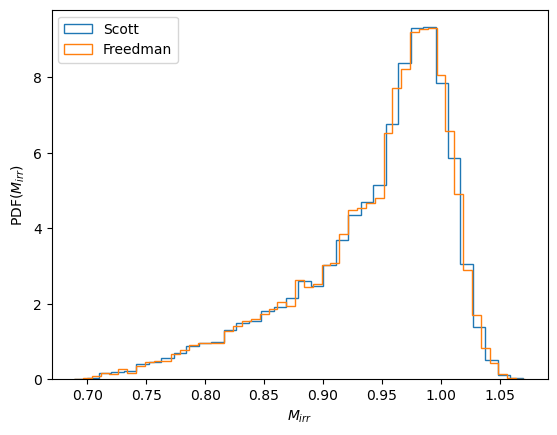

In [4]:
# Different binning rules
fig = plt.figure()
Scott = fancyhist(M_irr(X, M), bins = "scott", histtype = "step", density = True, label = 'Scott')
Freedman = fancyhist(M_irr(X, M), bins = "freedman", histtype = "step", density = True, label = 'Freedman')
plt.xlabel('$M_{irr}$')
plt.ylabel('PDF($M_{irr}$)')
plt.legend()
plt.show()

Now I can plot a KDE over the histograms, at first I try with different widths 

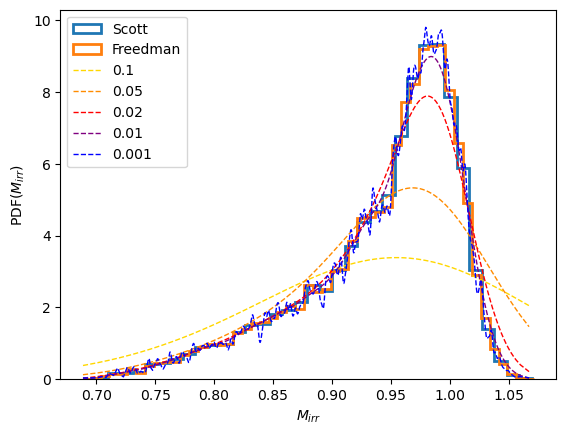

In [5]:
fig = plt.figure()
Scott = fancyhist(M_irr(X, M), bins = "scott", histtype = "step", density = True, label = 'Scott', lw = 2)
Freedman = fancyhist(M_irr(X, M), bins = "freedman", histtype = "step", density = True, label = 'Freedman', lw = 2)
plt.xlabel('$M_{irr}$')
plt.ylabel('PDF($M_{irr}$)')
plt.legend()

M_irr_vec = np.sort(M_irr(X, M))

# Plotting the KDE
bandwidth = [['0.1',0.1], ['0.05',0.05], ['0.02',0.02], ['0.01',0.01], ['0.001', 0.001]]
colors = ['gold', 'darkorange', 'red', 'purple', 'blue']

KDE_plot(M_irr_vec[:, np.newaxis], bandwidth, colors)
plt.show()

The best way to fix the width is to go with a CV over a set of bandwiths. Let's see what is the result!

In [6]:
# GridSearch to pick the best width for the kernel
# the score for the KDE is the total log-likelihood under the model

bwrange = np.linspace(0.001, 0.05, 20)
M_irr_in = shuffle(M_irr_vec)
K = 10 

grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv = K)
grid.fit(M_irr_in[:, np.newaxis])
h_opt = grid.best_params_['bandwidth']
print('Optimal bandwidth: %.04f' %h_opt)

Optimal bandwidth: 0.0062


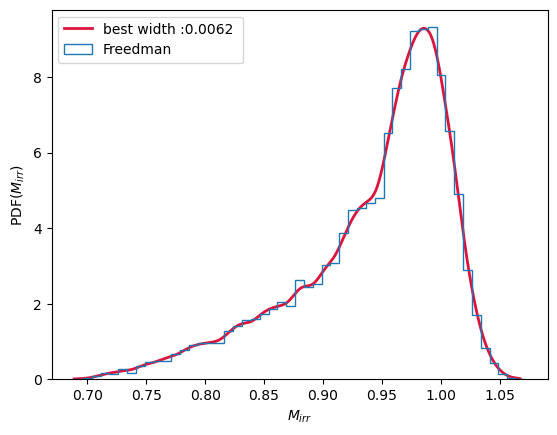

In [7]:
fig = plt.figure()
kde = KernelDensity(kernel = 'gaussian', bandwidth = h_opt) 
kde.fit(M_irr_in[:, np.newaxis]) 
log_pdf = kde.score_samples(M_irr_vec[:, np.newaxis])
likelihood = np.exp(log_pdf)
plt.plot(M_irr_vec, likelihood, label = 'best width :{:0.4f} '.format(h_opt), lw = 2, c = 'crimson')
Freedman = fancyhist(M_irr_in, bins = "freedman", histtype = "step", density = True, label = 'Freedman')
plt.xlabel('$M_{irr}$')
plt.ylabel('PDF($M_{irr}$)')
plt.legend()
plt.show()


## KS Test

The KS is a statistics based on the distance between two CDF distributions, in this case we can plot the Empirical CDF from the dsta al look at the situation; The distance should depend on the value of $\sigma$, I pick two values just to show the canghe by eye and to clarify the KS results. I choose: $\sigma = [0.02 ; 1]$ .

<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\s'
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_44733/3392586079.py:32: SyntaxWarning: invalid escape sequence '\s'
  plt.title('M vs $M_{irr}, \sigma = 0.02$')
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_44733/3392586079.py:40: SyntaxWarning: invalid escape sequence '\s'
  plt.title('M vs $M_{irr}, \sigma = 1$')


Text(0, 0.5, 'CDF')

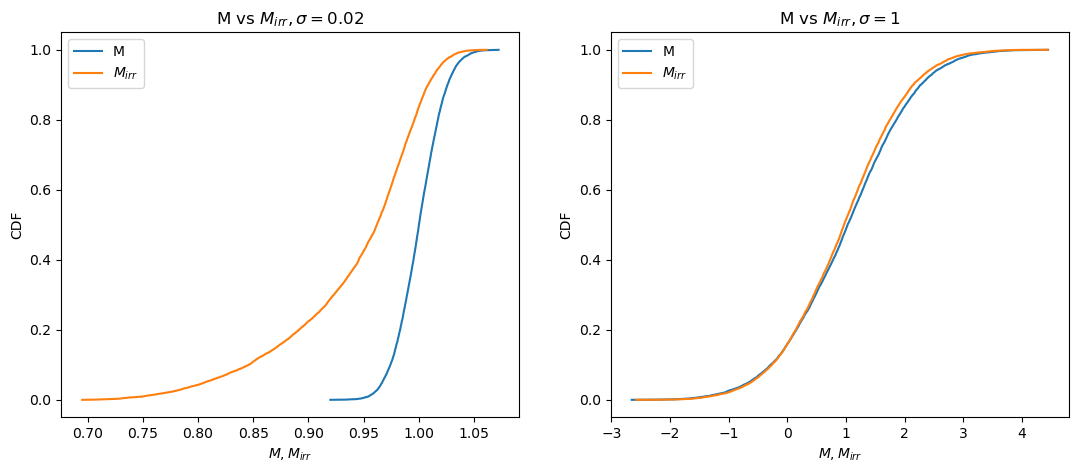

In [8]:
# The two gaussians:
M = np.random.normal(1, 0.02, 10000) # Mass
M_1 = np.random.normal(1, 1, 10000) 

# M_irr
M_irr_0 = M_irr(X, M)
M_irr_1 = M_irr(X, M_1)

# f depends onfly on X
f_mass = f(X)

# scipy implementation of the ECDF
# Alternative: cdf = np.arange(1, len(M_irr)+1)/len(M_irr)
# for each datapoint I add one and divide for the total number of datapoints

CDF_M_1 = sp.ecdf(M_1)
CDF_M_1_plot = CDF_M_1.cdf.evaluate(np.sort(M_1))

CDF_M = sp.ecdf(M)
CDF_M_plot = CDF_M.cdf.evaluate(np.sort(M))

CDF_M_irr_0 = sp.ecdf(M_irr_0)
CDF_0_plot = CDF_M_irr_0.cdf.evaluate(np.sort(M_irr_0))

CDF_M_irr_1 = sp.ecdf(M_irr_1)
CDF_1_plot = CDF_M_irr_1.cdf.evaluate(np.sort(M_irr_1))

fig = plt.figure(figsize = (13, 5))

ax = fig.add_subplot(121)
ax.plot(np.sort(M), CDF_M_plot, label = 'M')
ax.plot(np.sort(M_irr_0), CDF_0_plot, label = '$M_{irr}$')
plt.title('M vs $M_{irr}, \sigma = 0.02$')
plt.xlabel('$M, M_{irr}$')
plt.ylabel('CDF')
plt.legend()

ax = fig.add_subplot(122)
ax.plot(np.sort(M_1), CDF_M_1_plot, label = 'M')
ax.plot(np.sort(M_irr_1), CDF_1_plot, label = '$M_{irr}$')
plt.title('M vs $M_{irr}, \sigma = 1$')
plt.xlabel('$M, M_{irr}$')
plt.legend()
plt.ylabel('CDF')


<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_44733/3390388619.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.title('f vs $M_{irr}, \sigma = 0.02$')
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_44733/3390388619.py:20: SyntaxWarning: invalid escape sequence '\s'
  plt.title('f vs $M_{irr}, \sigma = 1$')


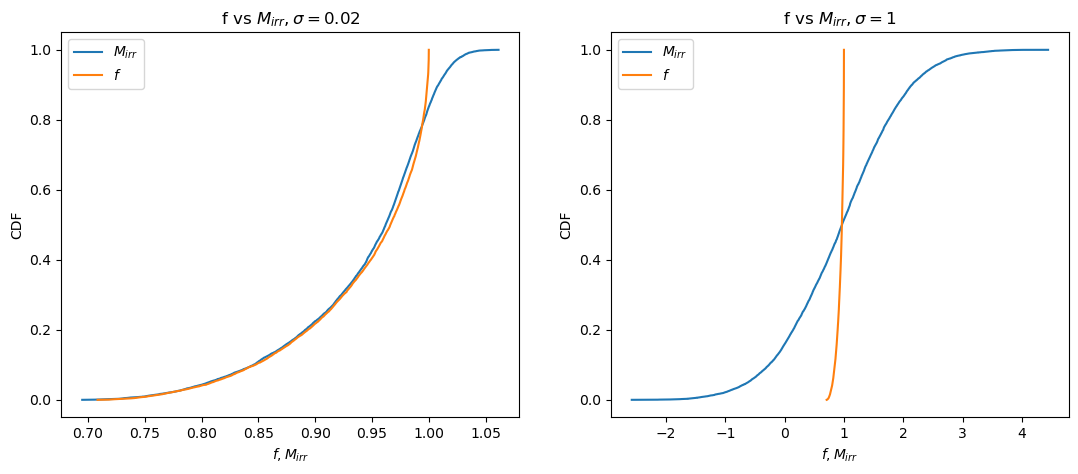

In [9]:
fig = plt.figure(figsize = (13, 5))

# scipy implementation of the ECDF
# Alternative: cdf = np.arange(1, len(m_irr)+1)/len(m_irr)

CDF_f = sp.ecdf(f_mass)
CDF_f_plot = CDF_f.cdf.evaluate(np.sort(f_mass))

ax = fig.add_subplot(121)
ax.plot(np.sort(M_irr_0), CDF_0_plot, label = '$M_{irr}$')
ax.plot(np.sort(f_mass), CDF_f_plot, label = '$f$')
plt.title('f vs $M_{irr}, \sigma = 0.02$')
plt.xlabel('$f, M_{irr}$')
plt.ylabel('CDF')
plt.legend()

ax = fig.add_subplot(122)
ax.plot(np.sort(M_irr_1), CDF_1_plot, label = '$M_{irr}$')
ax.plot(np.sort(f_mass), CDF_f_plot, label = '$f$')
plt.title('f vs $M_{irr}, \sigma = 1$')
plt.xlabel('$f, M_{irr}$')
plt.ylabel('CDF')
plt.legend()

<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_44733/2285903748.py:26: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma$')
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_44733/2285903748.py:35: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma$')


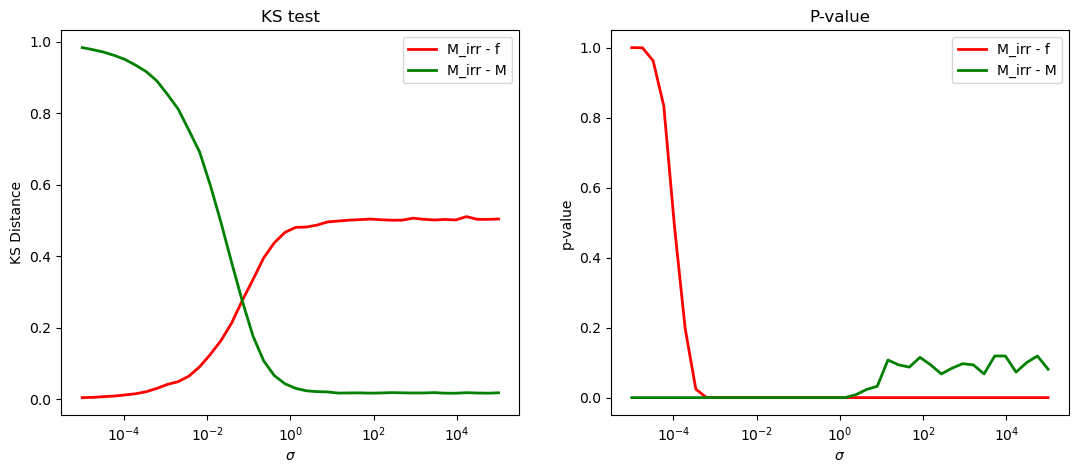

In [10]:
# sigmas = np.logspace(1e-5, 1e5, 40) Why this work in strange way!?

sigmas = np.logspace(-5, 5, 40) 
X = np.random.uniform(0, 1 , 10000) # Spin

KS_tests_1 = []
KS_pval_1 = []
KS_tests_2 = []
KS_pval_2 = []

# KS tests and p-value
for i in sigmas:
        
    M = np.random.normal(1, i, 10000)
        
    KS_tests_1.append( (sp.ks_2samp(M_irr(X, M), f(X)).statistic) )
    KS_pval_1.append( (sp.ks_2samp(M_irr(X,M), f(X)).pvalue) )
    KS_tests_2.append( (sp.ks_2samp(M_irr(X,M), M).statistic) )
    KS_pval_2.append( (sp.ks_2samp(M_irr(X,M), M).pvalue) )
 
fig = plt.figure(figsize = (13, 5))

ax = fig.add_subplot(121)
ax.plot(sigmas, KS_tests_1, lw = 2, c = 'red', label = 'M_irr - f')
ax.plot(sigmas, KS_tests_2, lw = 2, c = 'green', label = 'M_irr - M')
plt.xlabel('$\sigma$')
plt.xscale('log')
plt.ylabel('KS Distance')
plt.title('KS test')
plt.legend()

ax = fig.add_subplot(122)
ax.plot(sigmas, KS_pval_1, lw = 2, c = 'red', label = 'M_irr - f')
ax.plot(sigmas, KS_pval_2, lw = 2, c = 'green', label = 'M_irr - M')
plt.xlabel('$\sigma$')
plt.ylabel('p-value')
plt.xscale('log')
plt.title('P-value')
plt.legend()
plt.show()


Generally, if the p-value is small I would reject the null hypotesis; in this case
the null hypotesis is relted to the KS test: are the two samples drawn from the same distribution? 


If the p-value is 'small', I can reject the null hypotesis; from the graph we can see 
that for small sigmas the p-value of $M_{irr}$ - f is high and for $M_{irr}$ - M is low
This means that $M_{irr}$ is like f distribution for small sigma, on the other hand, for 
large sigmas the $M_{irr}$ distribution is more like the M distribution.
You can check it using the KS distance but also from the CDFs plots

## Comparing the distributions

Now I compare the distributions for different $\sigma$ with the distribution from the KDE

In [13]:
# pdf for f 
def f_pdf (x):
    
    return 2 * (2 * x**2 - 1)/(1 - x**2)**0.5

# Integrand for pdf of M_irr
def M_integral (mass, f, sigma):

    return np.sqrt(2 / np.pi) / sigma * np.exp( -(mass/f - 1)**2 / (2 * sigma**2)) * (2 * f**2 - 1)/(f * np.sqrt(1 - f**2))
    
# pdf for M_irr
def M_irr_pdf (sigma, Mass, grid, x_unif):
    
    # Computing the pdf for M_irr doing an integral
    M_irr_pdf = [quad(lambda f: M_integral(x, f, sigma), 1/np.sqrt(2), 1)[0] for x in grid]

    # Computing the KDE
    kde = KernelDensity(kernel = 'gaussian', bandwidth = 0.0062) # Best binwidth 0.0064 (too small?)
    kde.fit(M_irr(x_unif, Mass)[:, np.newaxis]) 
    log_pdf = kde.score_samples(np.sort(M_irr(x_unif, Mass))[:, np.newaxis])
    likelihood = np.exp(log_pdf)
    
    fig = plt.figure()
    plt.plot(X_grid, M_irr_pdf, lw = 2, c = 'red', label = 'Theorical $M_{irr}$ pdf')
    Freedman = fancyhist(M_irr(x_unif, Mass), bins = "freedman", histtype = "step", density=True, label = 'Freedman', color = 'seagreen')
    plt.plot(np.sort(M_irr(x_unif, Mass)), likelihood, label = 'KDE', lw = 2, c = 'blue', ls = '--')
    plt.xlabel('$M_{irr}$')
    plt.legend()
    plt.show()

    return

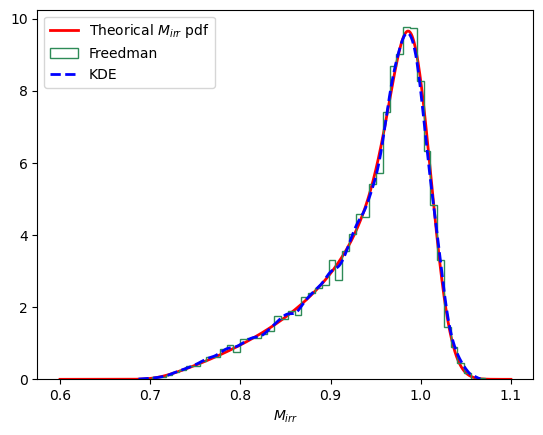

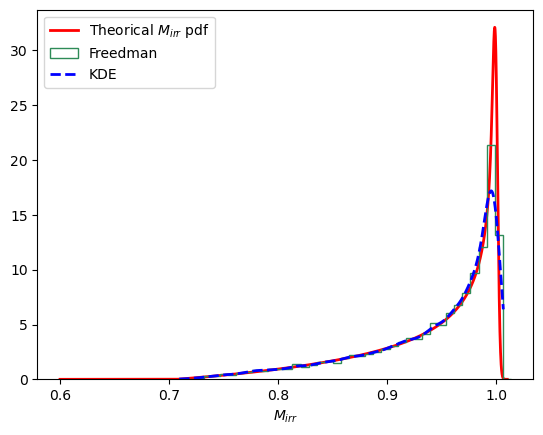

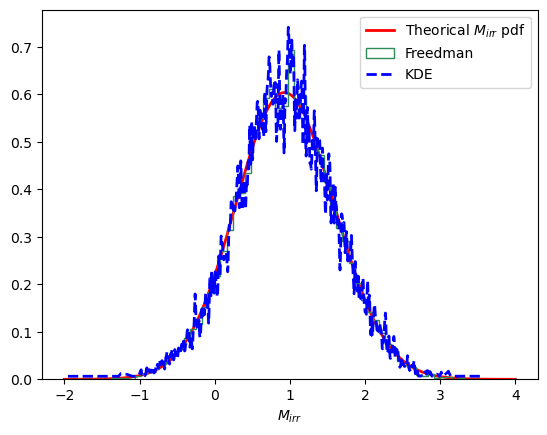

In [18]:
# I'm checking the pdf of M_irr is correct
sigma = 0.02
M = np.random.normal(1, sigma, 10000)
X_grid = np.random.uniform(0.6, 1.1, 10000)
X_grid = np.sort(X_grid)
    
M_irr_pdf(sigma, M, X_grid, X)

# Now I assume the sigma small (sigma << mu)
sigma = 0.002
M = np.random.normal(1, sigma, 10000)
X_grid = np.random.uniform(0.6, 1.01, 10000)
X_grid = np.sort(X_grid)

M_irr_pdf(sigma, M, X_grid, X)

# Now increase the sigma (sigma ~ mu)
sigma = 0.7
M = np.random.normal(1, sigma, 10000)
X_grid = np.random.uniform(-2, 4, 10000)
X_grid = np.sort(X_grid)

M_irr_pdf(sigma, M, X_grid, X)

# When the sigma increases, the distribution of M_irr is the distribution of M


For the last one a different width is necessary, I tried with 0.1 and works quite well. In principle, you can do CV to get for all the different cases the optimal width of the KDE